In [2]:
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from skin_tone_estimator import get_skin_tone_RGB

In [3]:
# For visualisation
def showImage(title, image):
    cv2.imshow(title, image)
    cv2.moveWindow(title,0,0)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def printImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    
def rfFeaturePlot(rf_reg, col_list, plot=True, title="Feature importances"):
    #we can call this built-in property, which is provided by the sklearn to get the feature_importances_ scire
    importances = rf_reg.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    if plot:
        # Plot the feature importances of the forest
        plt.figure(1,(15,9))
        plt.title(title)
        plt.bar(range(rf_reg.n_features_), importances[indices],  
               color="r", align="center")
        plt.xticks(range(rf_reg.n_features_),col_list[indices], rotation='vertical', fontsize=15)
#         plt.xlim([-1,rf_reg.n_features_)
        plt.xlim([-1, 20.5])
        plt.ylabel('Relative Importance')
        plt.show()
        
def svc_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
# def svc_importances(coef, names, top=-1):
#     imp = coef
#     imp, names = zip(*sorted(list(zip(imp, names))))

#     # Show all features
#     if top == -1:
#         top = len(names)

#     plt.barh(range(top), imp[::-1][0:top], align='center')
#     plt.yticks(range(top), names[::-1][0:top])
#     plt.show()

In [66]:
IMAGES_DATA_PKL_PATH = "./images_dataset.pkl"
IMAGES_PATH = "../data/filtered_image_pool"
filtered_images_df = pd.read_pickle(IMAGES_DATA_PKL_PATH)

In [67]:
filtered_images_df[['image_name', 'face_landmark', 'race']]

,image_name,face_landmark,race
0,10_0_0_20161220222308131.jpg,"[[54, 116], [60, 159], [71, 201], [78, 239], [...",0
1,10_0_0_20170103200329407.jpg,"[[97, 348], [104, 402], [109, 458], [118, 514]...",0
2,10_0_0_20170103200522151.jpg,"[[134, 360], [138, 420], [146, 479], [162, 536...",0
3,10_0_0_20170103233459275.jpg,"[[226, 119], [229, 149], [237, 178], [241, 206...",0
4,10_0_0_20170104013211746.jpg,"[[85, 101], [86, 113], [88, 123], [90, 134], [...",0
...,...,...,...
20130,9_1_3_20161220222856346.jpg,"[[451, 337], [450, 360], [452, 385], [457, 406...",3
20131,9_1_3_20170104222949455.jpg,"[[170, 167], [170, 182], [173, 195], [175, 208...",3
20132,9_1_4_20170103200637399.jpg,"[[51, 357], [58, 415], [65, 469], [73, 525], [...",4
20133,9_1_4_20170103200814791.jpg,"[[76, 342], [81, 400], [89, 454], [99, 509], [...",4


In [10]:
fl1 = filtered_images_df.iloc[0, :]['face_landmark']

In [38]:
df_cols = ["image_name", "face_height_to_width", "eyes_distance_to_width", "eyes_nose_to_height", 
           "eyes_mouth_to_height", "lips_thickness_to_height", "lips_length_to_width",  
           "nose_mouth_to_height", "nose_width_to_width", "nose_width_to_eye_distance", 
            "eyes_width_to_eyes_height",  "chin_height_to_height", "eyebrows_eyes_to_height",
           "lips_width_to_lips_height", "skin_color_r","skin_color_g", "skin_color_b", "race"]

to_add = {}
for col in df_cols:
    to_add[col] = []

new_df = pd.DataFrame(columns=df_cols)
counter = 0
for _, row in filtered_images_df.iterrows():
    counter += 1
    if counter%100 == 0:
        print("Processed", counter)
        
    img_path = os.path.join(IMAGES_PATH, row['image_name'])
    img = cv2.imread(img_path)
    skin_tone = get_skin_tone_RGB(img)
    if not skin_tone:
        continue
    
    fl = row['face_landmark']
    face_width = np.max(fl[:,0]) - np.min(fl[:,0])
    face_height = np.max(fl[:,1]) - np.min(fl[:,1])
    
    max_eyes_y = np.max(fl[36:48,1])
    min_eyes_y = np.min(fl[36:48,1])
    max_eyes_x = np.max(fl[36:48,0])
    min_eyes_x = np.min(fl[36:48,0])
    
    max_nose_y = np.max(fl[31:36,1])
    middle_nose_x = fl[33,0]
    max_nose_x = np.max(fl[31:36,0])
    min_nose_x = np.min(fl[31:36,0])
    
    
    max_outer_lips_y = np.max(fl[55:60,1])
    min_outer_lips_y = np.min(fl[49:54,1])
    max_inner_lips_y = np.max(fl[65:68,1])
    min_inner_lips_y = np.min(fl[61:64,1])
    
    max_lips_x = np.max(fl[48:68,0])
    min_lips_x = np.min(fl[48:68,0])
    
    eyebrows_to_eye = np.min(fl[36:42,1]) - np.min(fl[17:22,1])
    
    
    chin_y = fl[8,1]
    to_add["image_name"].append(row["image_name"])
    to_add["face_height_to_width"].append(face_height / face_width)
    to_add["eyes_distance_to_width"].append((max_eyes_x - min_eyes_x)/face_width)
    to_add["eyes_nose_to_height"].append((max_nose_y - max_eyes_y)/face_height)
    to_add["eyes_mouth_to_height"].append((min_outer_lips_y - max_eyes_y)/face_height)
    to_add["lips_thickness_to_height"].append((max_outer_lips_y - max_inner_lips_y + min_inner_lips_y - min_outer_lips_y)/face_height)
    to_add["lips_length_to_width"].append((max_lips_x - min_lips_x)/face_width)
    to_add["nose_mouth_to_height"].append((min_outer_lips_y - max_nose_y)/face_height)
    to_add["nose_width_to_width"].append((max_nose_x - min_nose_x)/face_width)
    to_add["nose_width_to_eye_distance"].append((max_nose_x - min_nose_x)/(max_eyes_x - min_eyes_x))
    to_add["eyes_width_to_eyes_height"].append((max_eyes_x - min_eyes_x)/(max_eyes_y - min_eyes_y))
    to_add["chin_height_to_height"].append((chin_y - max_outer_lips_y)/face_height)
    to_add["eyebrows_eyes_to_height"].append(eyebrows_to_eye/face_height)
    to_add["lips_width_to_lips_height"].append((max_lips_x - min_lips_x)/(max_outer_lips_y - max_inner_lips_y + min_inner_lips_y - min_outer_lips_y))
    to_add["skin_color_r"].append(skin_tone[0])
    to_add["skin_color_g"].append(skin_tone[1])
    to_add["skin_color_b"].append(skin_tone[2])
    to_add["race"].append(row['race'])
    
to_add_df = pd.DataFrame(to_add)
new_df = new_df.append(to_add_df, ignore_index = True)

Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600
Processed 1700
Processed 1800
Processed 1900
Processed 2000
Processed 2100
Processed 2200
Processed 2300
Processed 2400
Processed 2500
Processed 2600
Processed 2700
Processed 2800
Processed 2900
Processed 3000
Processed 3100
Processed 3200
Processed 3300
Processed 3400
Processed 3500
Processed 3600
Processed 3700
Processed 3800
Processed 3900
Processed 4000
Processed 4100
Processed 4200
Processed 4300
Processed 4400
Processed 4500
Processed 4600
Processed 4700
Processed 4800
Processed 4900
Processed 5000
Processed 5100
Processed 5200
Processed 5300
Processed 5400
Processed 5500
Processed 5600
Processed 5700
Processed 5800
Processed 5900
Processed 6000
Processed 6100
Processed 6200
Processed 6300
Processed 6400
Processed 6500
Processed 6600
Processed 6700
Proc

In [41]:
# new_df.to_csv("preprocessed_data.csv")

In [72]:
new_df = pd.read_csv("preprocessed_data.csv")

In [73]:
data_input = new_df[[col for col in new_df.columns if col not in ['skin_color_r', 'skin_color_g','skin_color_b']]]
data_input

,image_name,face_height_to_width,eyes_distance_to_width,eyes_nose_to_height,eyes_mouth_to_height,lips_thickness_to_height,lips_length_to_width,nose_mouth_to_height,nose_width_to_width,nose_width_to_eye_distance,eyes_width_to_eyes_height,chin_height_to_height,eyebrows_eyes_to_height,lips_width_to_lips_height,race
0,10_0_0_20161220222308131.jpg,0.872727,0.615152,0.322917,0.406250,0.135417,0.366667,0.083333,0.166667,0.270936,9.666667,0.239583,0.135417,3.102564,0
1,10_0_0_20170103200329407.jpg,0.930288,0.588942,0.341085,0.405685,0.072351,0.471154,0.064599,0.192308,0.326531,11.136364,0.273902,0.111111,7.000000,0
2,10_0_0_20170103200522151.jpg,0.907801,0.572104,0.330729,0.432292,0.088542,0.385343,0.101562,0.158392,0.276860,8.066667,0.231771,0.125000,4.794118,0
3,10_0_0_20170103233459275.jpg,0.884956,0.610619,0.325000,0.435000,0.120000,0.309735,0.110000,0.159292,0.260870,10.615385,0.215000,0.155000,2.916667,0
4,10_0_0_20170104013211746.jpg,0.955556,0.611111,0.302326,0.383721,0.093023,0.422222,0.081395,0.200000,0.327273,9.166667,0.232558,0.127907,4.750000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19466,9_1_3_20161220222856346.jpg,0.923077,0.605769,0.291667,0.348958,0.104167,0.500000,0.057292,0.216346,0.357143,12.600000,0.208333,0.140625,5.200000,3
19467,9_1_3_20170104222949455.jpg,0.981982,0.693694,0.256881,0.348624,0.137615,0.378378,0.091743,0.198198,0.285714,9.625000,0.247706,0.183486,2.800000,3
19468,9_1_4_20170103200637399.jpg,0.939148,0.638945,0.246220,0.354212,0.103672,0.395538,0.107991,0.202840,0.317460,12.600000,0.278618,0.187905,4.062500,4
19469,9_1_4_20170103200814791.jpg,0.846652,0.615551,0.298469,0.377551,0.081633,0.457883,0.079082,0.200864,0.326316,9.827586,0.252551,0.137755,6.625000,4


# Dataset train test split

In [5]:
X_col = [col for col in new_df.columns if col not in ['image_name', 'race', "skin_color_r","skin_color_g", "skin_color_b"]]
X_df = new_df[X_col]
Y_df = new_df[['race']]
X = X_df
y = Y_df.astype('int').values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Logistic Regression (OvR)

In [13]:
model = LogisticRegression()
model.fit(X_train, y_train)

#=== model evaluation ===
y_pred = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("Training accuracy: {}".format(model.score(X_train, y_train)))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
print('Test score: %.3f' % model.score(X_test, y_test))

Training accuracy: 0.5824345146379045
Average 5-Fold CV Score: 0.5785178553399118
Test score: 0.578


In [15]:
# no penalty needed since not overfitting
model = LogisticRegression(penalty= "none", max_iter = 5000)
model.fit(X_train, y_train)

#=== model evaluation ===
y_pred = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("Training accuracy: {}".format(model.score(X_train, y_train)))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
print('Test score: %.3f' % model.score(X_test, y_test))

Training accuracy: 0.6285952747817155
Average 5-Fold CV Score: 0.6287242359117855
Test score: 0.618


# SVC

Training accuracy: 0.6151771956856703
Average 5-Fold CV Score: 0.612288504214771
Test score: 0.605
white


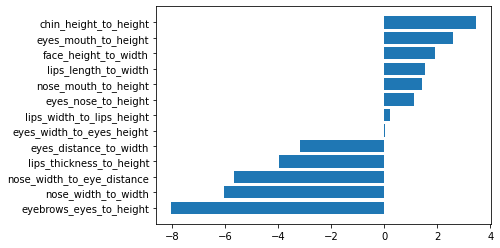

black


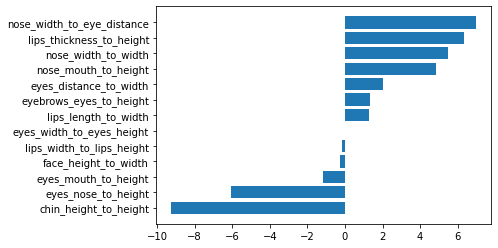

asian


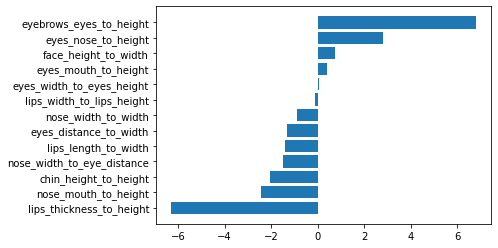

indian


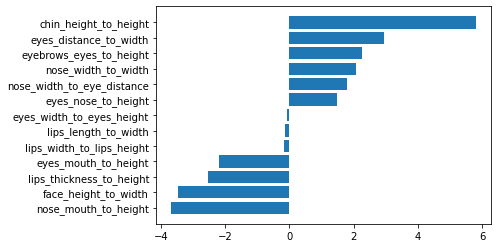

others


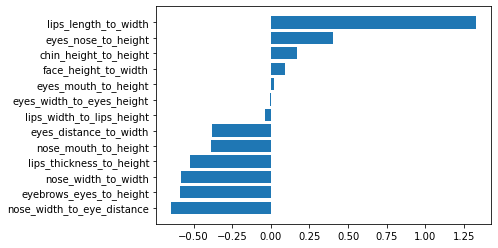

In [42]:
# no penalty needed since not overfitting
model = LinearSVC(dual=False)
model.fit(X_train, y_train)

#=== model evaluation ===
y_pred = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("Training accuracy: {}".format(model.score(X_train, y_train)))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
print('Test score: %.3f' % model.score(X_test, y_test))
for i, coef in enumerate(model.coef_):
    print(target[i])
    svc_importances(coef, X_df.columns)

Training accuracy: 0.6178736517719569
Average 5-Fold CV Score: 0.61793821357999
Test score: 0.609
              precision    recall  f1-score   support

       white       0.62      0.87      0.73      1712
       black       0.61      0.77      0.68       782
       asian       0.50      0.22      0.30       473
      indian       0.57      0.26      0.35       673
      others       0.00      0.00      0.00       255

    accuracy                           0.61      3895
   macro avg       0.46      0.42      0.41      3895
weighted avg       0.55      0.61      0.55      3895

white


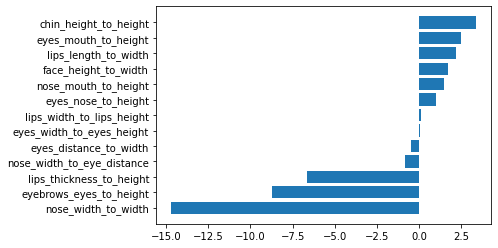

black


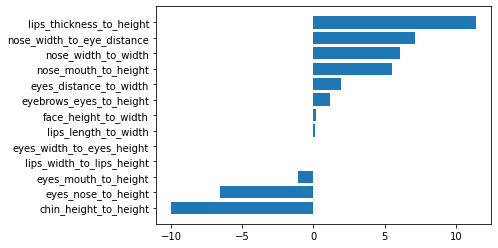

asian


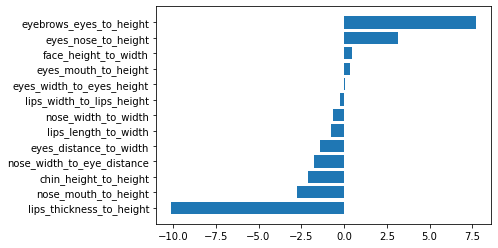

indian


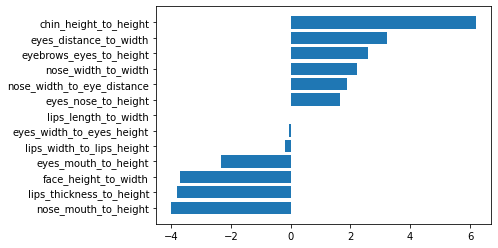

others


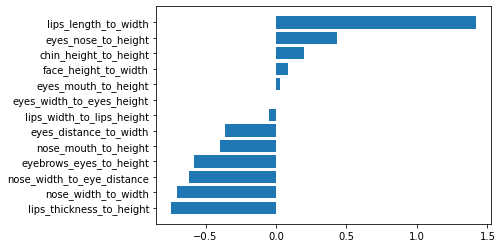

In [35]:
model = LinearSVC(C = 10, dual=False)
model.fit(X_train, y_train)

#=== model evaluation ===
y_pred = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("Training accuracy: {}".format(model.score(X_train, y_train)))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
print('Test score: %.3f' % model.score(X_test, y_test))
target =["white", "black", "asian", "indian", "others"]
print(classification_report(y_test, y_pred, target_names=target))
for i, coef in enumerate(model.coef_):
    print(target[i])
    svc_importances(coef, X_df.columns)

Training accuracy: 0.6190934771443246
Average 5-Fold CV Score: 0.6176172687130267
Test score: 0.609
              precision    recall  f1-score   support

       white       0.62      0.87      0.73      1712
       black       0.61      0.77      0.68       782
       asian       0.49      0.22      0.30       473
      indian       0.57      0.26      0.35       673
      others       0.00      0.00      0.00       255

    accuracy                           0.61      3895
   macro avg       0.46      0.42      0.41      3895
weighted avg       0.56      0.61      0.55      3895

white


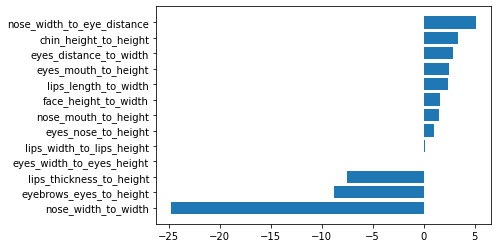

black


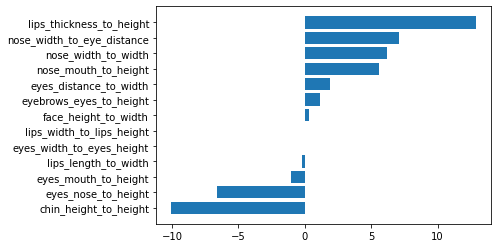

asian


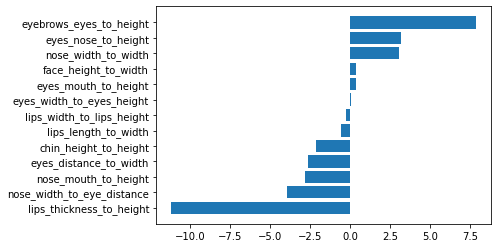

indian


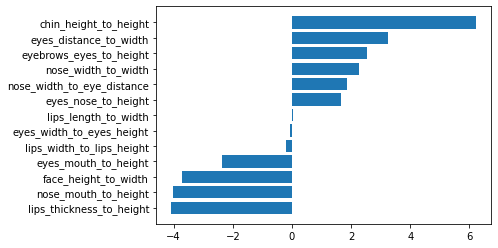

others


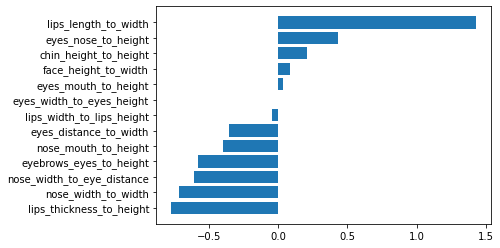

In [43]:
model = LinearSVC(C = 1000, dual=False)
model.fit(X_train, y_train)

#=== model evaluation ===
y_pred = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("Training accuracy: {}".format(model.score(X_train, y_train)))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
print('Test score: %.3f' % model.score(X_test, y_test))
target =["white", "black", "asian", "indian", "others"]
print(classification_report(y_test, y_pred, target_names=target))
for i, coef in enumerate(model.coef_):
    print(target[i])
    svc_importances(coef, X_df.columns)

# Random Forest

In [20]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

#=== model evaluation ===
y_pred = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("Training accuracy: {}".format(model.score(X_train, y_train)))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
print('Test score: %.3f' % model.score(X_test, y_test))

Training accuracy: 0.9980739599383667
Average 5-Fold CV Score: 0.6383544363786968
Test score: 0.633


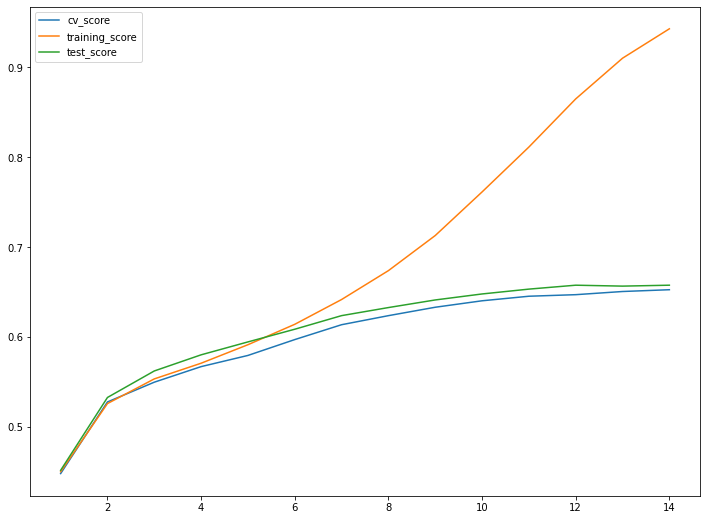

In [24]:
cv_score = []
training_score = []
test_score = []
start = 1
for i in range(start, 15):
    model = RandomForestClassifier(max_depth=i)
    model.fit(X_train, y_train)
    #=== model evaluation ===
    y_pred = model.predict(X_test)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
    cv_score.append(np.mean(cv_scores))
    training_score.append(model.score(X_train, y_train))
    test_score.append(model.score(X_test, y_test))
plt.figure(figsize=(12,9))
plt.plot(list(range(start, len(cv_score)+start)), cv_score, label = "cv_score")
plt.plot(list(range(start, len(training_score)+start)), training_score, label = "training_score")
plt.plot(list(range(start, len(test_score)+start)), test_score, label = "test_score")
plt.legend(loc='best')
plt.show()

Training accuracy: 0.6203133025166924
Average 5-Fold CV Score: 0.6015668521811517
Test score: 0.591


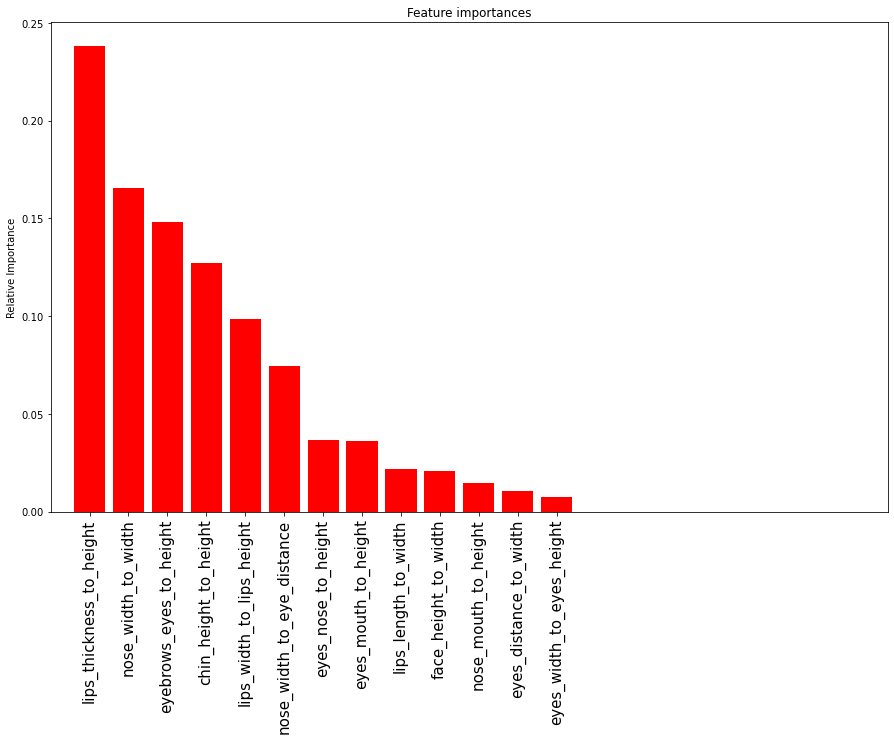

In [23]:
model = RandomForestClassifier(max_depth=6)
model.fit(X_train, y_train)

#=== model evaluation ===
y_pred = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("Training accuracy: {}".format(model.score(X_train, y_train)))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
print('Test score: %.3f' % model.score(X_test, y_test))
rfFeaturePlot(model, X_df.columns)